# GDP, GROWTH and World Development Indicators

The aim of this study is to explore the relationship between a country's governance and two important socioeconomic indicators - income inequality and economic growth. To achieve this, we have utilized data from the World Bank, which includes information on GINI, GDP, and governance indicators.

Specifically, we have obtained GINI and GDP data from the World Bank and stored it in a CSV file and accessed governance indactors from an API provided by the world bank. The governance indicators developed by the world bank, provides a set of aggregate and individual governance indicators for over 200 countries and territories, covering six dimensions of governance, namely Voice and Accountability, Political Stability and Absence of Violence/Terrorism, Government Effectiveness, Regulatory Quality, Rule of Law, and Control of Corruption.

Thus, by analyzing the data obtained from the World bank, we seek to investigate how the quality of a country's governance influences its level of income inequality and economic growth and hereby shed light on the importance of governance in the shaphing of a country's socioeconomic outcomes. 


In [20]:
#Imports and set magics:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from pandas_datareader import wb
import statsmodels.api as sm 
from sklearn import datasets
import matplotlib.cbook as cbook
from IPython.display import display
from ipywidgets import interact
import ipywidgets as widgets
from pandas_datareader import wb
import seaborn as sns
from scipy.stats import linregress
from scipy import signal

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject_unfucked as dataproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data
The World Bank data for GINI and GDP is accessed through an API for different countries in the period 1990-2017. The API is embedded in a function called my_wb_downloader which is designed to download and clean World Bank data. The function takes four arguments, herof:

- 'in_country' which is a string specifying the countries for which data will be downloaded

- 'varlist_as_dict' containing the variable names to be downloaded

- 'start_year' which is the starting year of the data to be downloaded 

- 'end_year' with is the end year of the data to be downloaded. 


In [2]:
# List of variables to rename
wb_variables_with_new_names = {'SI.POV.GINI'   :'GINI',
                                'NY.GDP.PCAP.KD':'GDP',
                               'NY.GDP.PCAP.KD.ZG':'GDP_growth'}
# Download and clean data
wb1 = dataproject.my_wb_downloader('all', wb_variables_with_new_names, 1990, 2017)

# Print data
wb1.sample(5)

,country,year,GINI,GDP,GDP_growth
7178,Uruguay,2007,46.4,11255.698984,6.337656
6969,Turkmenistan,1992,NaN,2715.932040,-17.231044
2342,Cameroon,1999,NaN,1124.900473,1.778363
4355,Kuwait,2002,NaN,30886.369515,0.212209
3525,Greece,1992,NaN,15805.662924,-0.066299


The World Governance Indicators could not be accessed through an API. Thus, these indicators were downloaded into a CSV file. This is evident from the code provided below:

In [24]:
frame= dataproject.WGI_DataFrame("WB WGI Levels.csv")

0 Now rename Series Control of Corruption: Estimate = COC
1 Now rename Series Government Effectiveness: Estimate = GOV
2 Now rename Series Political Stability and Absence of Violence/Terrorism: Estimate = RSA
3 Now rename Series Regulatory Quality: Estimate = REQ
4 Now rename Series Rule of Law: Estimate = ROL
5 Now rename Series Voice and Accountability: Estimate = VOA


Both datasets contain the variables year and country, allowing for a merge to be peformed between the two datasets on this basis. Subsequently, we transform the merged data to a long format rendering it possible to regress GINI, GDP and the governance indicators on each other. 

In [25]:
final=dataproject.merge(wb1,frame)

# Descriptive statistics

We observe that we have 6624 observations of GDP, 1611 observations of GINI and 4619 observations of each WGI.

The World Governance Indicators (WGI) variables in the World bank data set are practically already normalized. However we still normalize them by mean and standard deviation to ensure valid enterpritation. From table 4-15 below it can be seen that the World Governance Indicators are stable over time as their mean is very close to 0 and they have a standard deviation equal to 1. This has the consequence that we can only use them to analyse the rank of the different countries, not for analyzing trends over time.

In [26]:
# Group variables
allyearslist = list(range(2002,2017))
subyearlist  = [2002, 2007, 2012, 2017]

# List of all governance index variables
varlist_wgi = ['COC','GOV', 'RSA', 'REQ', 'ROL', 'VOA']

# List of all normalized governance index variables
varlist_wgi_norm = list(map(lambda x: x + '_norm', varlist_wgi))

# List of all variables
varlist_all = ['GDP', 'GINI'] + varlist_wgi

# Ensure all variables are perfectly normalized within year
final = dataproject.standardize_by_group(final, varlist_wgi, 'year')

# Simple Descriptive Statistics
simplestats_noyear = dataproject.calc_simplestats(final, varlist_all, group_by_year=False)
simplestats = dataproject.calc_simplestats(final, varlist_all, group_by_year=True, groups_to_print=subyearlist)
simplestats_norm = dataproject.calc_simplestats(final, varlist_wgi_norm, group_by_year=True, groups_to_print=subyearlist)

# Print stats
print('N, Mean, Std. across all years')
display(simplestats_noyear)

# Print stats by year
for var in varlist_all:
    print(var)
    display(simplestats[var])

# Print normalized wgi stats by year
for var in varlist_wgi_norm:
    print(var)
    display(simplestats_norm[var])

N, Mean, Std. across all years


,GDP,GINI,COC,GOV,RSA,REQ,ROL,VOA
count,6624.000000,1577.000000,4619.000000,4619.000000,4619.000000,4619.000000,4619.000000,4619.000000
mean,11852.048243,38.268992,-0.010643,-0.008899,-0.028062,-0.007569,-0.022902,-0.024310
std,17624.031024,9.040012,0.999923,0.998163,0.996367,0.998880,1.003089,0.997422


GDP


,count,mean,std
year,,,
2002,229,11242.877165,16976.466283
2007,246,13321.879873,19591.879133
2012,251,13596.819953,18853.108183
2017,248,13899.362356,18753.806262


GINI


,count,mean,std
year,,,
2002,54,41.307407,9.622965
2007,70,36.481429,8.103055
2012,85,36.310588,7.231891
2017,76,35.507895,6.994164


COC


,count,mean,std
year,,,
2002,186,-0.003314,1.010104
2007,205,-0.001488,1.000923
2012,210,0.003180,1.004181
2017,202,-0.039934,0.990901


GOV


,count,mean,std
year,,,
2002,186,-6.809671e-10,1.000000
2007,205,-2.534813e-03,1.003514
2012,210,9.515541e-03,0.999963
2017,202,-3.019827e-02,1.001690


RSA


,count,mean,std
year,,,
2002,186,-0.007805,1.005875
2007,205,-0.015685,0.998778
2012,210,-0.009879,0.999587
2017,202,-0.045241,0.995372


REQ


,count,mean,std
year,,,
2002,186,-2.803982e-09,1.000000
2007,205,-8.804664e-04,1.004836
2012,210,9.753901e-03,0.999653
2017,202,-2.368051e-02,1.004438


ROL


,count,mean,std
year,,,
2002,186,-0.060509,1.016282
2007,205,-0.011584,1.004498
2012,210,-0.000605,1.001863
2017,202,-0.029992,1.000092


VOA


,count,mean,std
year,,,
2002,186,-0.068941,1.002485
2007,205,-0.014475,1.000576
2012,210,-0.004995,1.003467
2017,202,-0.010031,0.999662


COC_norm


,count,mean,std
year,,,
2002,186,-1.850372e-17,1.0
2007,205,-1.299773e-17,1.0
2012,210,-2.431917e-17,1.0
2017,202,9.893076e-18,1.0


GOV_norm


,count,mean,std
year,,,
2002,186,-1.134099e-17,1.0
2007,205,-1.733031e-17,1.0
2012,210,0.000000e+00,1.0
2017,202,-1.868692e-17,1.0


RSA_norm


,count,mean,std
year,,,
2002,186,-1.193788e-18,1.0
2007,205,1.353931e-17,1.0
2012,210,1.057355e-18,1.0
2017,202,-1.099231e-18,1.0


REQ_norm


,count,mean,std
year,,,
2002,186,-1.193788e-18,1.0
2007,205,2.653704e-17,1.0
2012,210,-7.401487e-18,1.0
2017,202,-9.893076e-18,1.0


ROL_norm


,count,mean,std
year,,,
2002,186,1.432546e-17,1.0
2007,205,-5.957294e-18,1.0
2012,210,-2.749124e-17,1.0
2017,202,1.758769e-17,1.0


VOA_norm


,count,mean,std
year,,,
2002,186,2.626334e-17,1.0
2007,205,1.137302e-17,1.0
2012,210,1.850372e-17,1.0
2017,202,-2.748077e-17,1.0


# Analysis

The analysis consists of 4 parts:
* First, we show the correlation between GINI, GDP and COC across time.
* Second, we show the correlation between GINI at a given point in time, and GDP growth 0, 10, 20 and 30 years later. 
* Third, we both show the correlation between GDP and the different WGI and GINI the different indicators.
* Fourth, we show the correlation between GINI in 2000 and the variance of detrended GDP in the subsequent 20 years.

We first present a scatter plot, which plots GINI on the x-axis and GDP on the y-axis for a given year. The dots, each representing a country are coloured based on their score on Control of Corruption (COC). We use our standardised version of the original measure from the World Governance Indicators.

If one slides through each year from 1996 to 2017 the first (trivial) observation is that countries move upwards over time due to economic growth. It seems as if the dots also move to the left over time - that they become more equal, but this could just be an artefact of the fact that the sample size of countries growing over time.

Lastly, countries with the same level of Control of Corruption seem to be clustered at the same income levels and not the level of economic equality. Countries with a low GDP tend to have a high level of corruption, but various different distributions of income, whereas countries with a higher income tend to have low levels of corrution, but also a more equal distribution of income.

In [23]:
dataproject.ScatterPlot(final,'GINI','GDP','COC_norm')

interactive(children=(Dropdown(description='year', options=(1996, 1998, 2000, 2002, 2003, 2004, 2005, 2006, 20…

The graph below shows the correlation between GINI at a given point in time and GDP growth 0, 20, 40 and 60, years later, in panel 1-4, respectively. In panel 2 and 4 the two variables are completely uncorrelated. In panel 1, and 3 on the other hand, there is a negative relationship between GINI and GDP. The countries who are more unequal tend to have a lower growth rate of GDP. The correlations are all economically insigificant as eg. GDP growth after 10 years is only .2 pct. points smaller if GINI was 10 points larger. The relationship is only statistically significant on a 1 pct. level after 40 years, where a one point larger GINI is associated with a -0.03 pct point lower GDP growth.

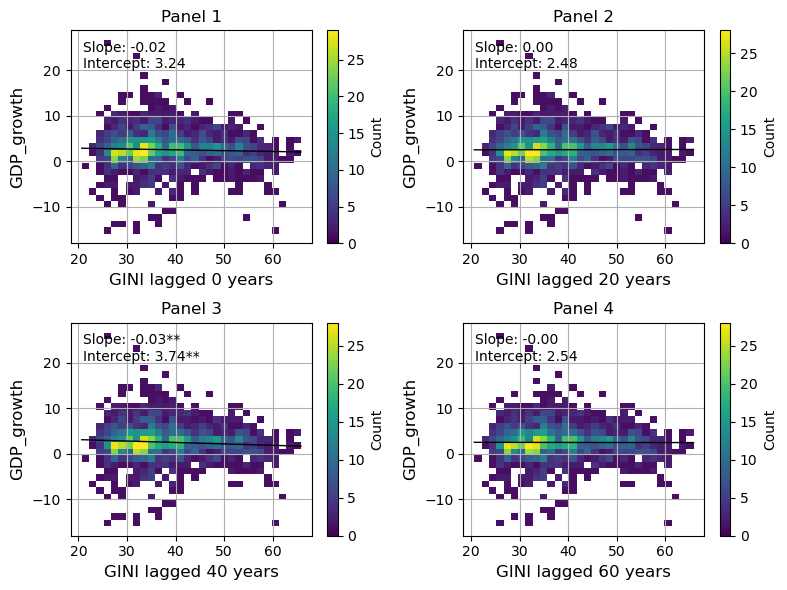

In [21]:
dataproject.corr(final,'GINI','GDP_growth')

The table below shows a regression of GDP and our standardised measures of the different WGI's in the same year.
Unsuprisingly, we find that GDP has a positive correlation with almost all of the WGIs. The only one which is not positive is the correlation between Voice and Accountability and the level of GDP. COC, GOV and VOA each has a statistically significant correlation with GDP on a 1 pct. level.

In [8]:
# a list named x_list1 is defined, which contains the names of the six independent variables.
x_list1 = ['COC_norm', 'GOV_norm', 'REQ_norm', 'ROL_norm', 'RSA_norm', 'VOA_norm']
reg_results1 = dataproject.regression(final,'GDP',x_list1)

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     166.9
Date:                Sun, 16 Apr 2023   Prob (F-statistic):          1.13e-185
Time:                        16:46:20   Log-Likelihood:                -36694.
No. Observations:                3298   AIC:                         7.340e+04
Df Residuals:                    3291   BIC:                         7.344e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.285e+04    287.030     44.752      0.0

We then turn to show how GINI is related to the different WGIs by regressing GINI on the six measures. Interestingly, It is positively correlated with three WGIs: COC, REQ and VOA, and negatively related to the other three. The picture is similar to the one shown in the scatter plot, where COC seemed to be much more tightly related to GDP than to GINI.

In [9]:
# a list named x_list2 is defined, which contains the names of the six independent variables.
x_list2 = ['COC_norm', 'GOV_norm', 'REQ_norm', 'ROL_norm', 'RSA_norm', 'VOA_norm']
reg_results1 = dataproject.regression(final,'GINI',x_list2)

                            OLS Regression Results                            
Dep. Variable:                   GINI   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     39.34
Date:                Sun, 16 Apr 2023   Prob (F-statistic):           7.56e-43
Time:                        16:46:20   Log-Likelihood:                -3340.5
No. Observations:                 958   AIC:                             6695.
Df Residuals:                     951   BIC:                             6729.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.7197      0.281    137.948      0.0

Note: The graph below is not credible, as the de-trending has not been done properly. We are currently searching for ways to resolve the problem. We interpret the available results anyway.

Lastly, we check whether countries who were more equal in year 2000 had a more variable GDP in the following 19 years (including year 2000). We detrend GDP and calculate the standard deviation of the resulting 20 year time series. Regressing the variance of detrended GDP on the WGI's in year 2000 shows that for COC, GOV, REQ and RSA countries with better scores had a higher variance og GDP, whereas it is negative for ROL and VOA. It is only statistically significant for VOA on a 5 pct. level, so the results should be interpreted with caution.

In [11]:
# We choose the explanatory varaibles and the years to be used in the regression.
years = range(2000, 2021)
year = 2000
x_list3 = ['COC_norm', 'GOV_norm', 'REQ_norm', 'ROL_norm', 'RSA_norm', 'VOA_norm']

dataproject.regression1(final,'GDP', x_list3, years, year)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
                            OLS Regression Results                            
Dep. Variable:                    std   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     8.444
Date:                Sun, 16 Apr 2023   Prob (F-statistic):           5.36e-08
Time:                        16:47:09   Log-Likelihood:                -1547.5
No. Observations:                 172   AIC:                             3109.
Df Residuals:                     165   BIC:                             3131.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

# Conclusion

In this assignment we have documented a strong, but extremely trivial empirical fact: that countries GDP grow over time. Secondly, and less trivially the WGI is more tightly related to the level of GDP than to the distribution thereof, given by the GINI coefficient. Lastly we have neither found evidence suggesting that more equal countries have a higher level of GDP as years pass nor that their GDP is less volatile in a 20 year period, after the GINI is measured.

We leave the much more difficult analysis of the causal relationship between inequality, GDP and WGI for future "Introduction to Programming and Numerical Analysis"-students.